# FIFA Players Classification

This notebook contains the code to train models for the FIFA Classification problem based on their attributes

## Step 1: Import libraries

Libraries we will be using:
- **tensorflow** and **keras**: APIs for neural network model construction and training
- **numpy**: Numerical python library.
- **pandas**: Will be used to work with dataframes from .csv files.
- **sklearn**: Will be used to modify the labels of the data and do some statistical modifications.
- **matplotlib**: Will be used to plot graphics.
- **time**: To measure training time.
- **datetime**: To get the datetime a new model is created and use that to create its name

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

## Step 2: Load data

We first define the path to our data

In [2]:
DATA_FOLDER = "../Data"

ATT_FILE = f"{DATA_FOLDER}/FootballPlayerPreparedCleanAttributes.csv"
IMPUTED_ATT_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/FootballPlayerOneHotEncodedClasses.csv"
IMPUTED_ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

Specify training options:
- **IMPUTED_DATA**: We will use file with data imputed
- **TRAIN_RATE**: The amount of instances to use during training, it will also determine the dev and test instances number indirectly

In [3]:
IMPUTED_DATA = False    # Use imputed dataset
TRAIN_RATE = 0.8        # The division of the data for training, validation and test

Because our data has more than 10000, we will be using 80-10-10 split in our dataset:
- **80%** for training
- **10%** for validation/dev test
- **10%** for final test

In [4]:
if IMPUTED_DATA:
    attributes = pd.read_csv(ATT_IMPUTED_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_IMPUTED_FILE)
else:
    attributes = pd.read_csv(ATT_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_FILE)

n_total_instances = attributes.shape[0]
n_train_instances = int(n_total_instances * TRAIN_RATE)
n_dev_instances = int((n_total_instances - n_train_instances)/2)

instances_train = attributes.values[:n_train_instances]
labels_train = labels.values[:n_train_instances]

instances_dev = attributes.values[n_train_instances: n_train_instances + n_dev_instances]
labels_dev = labels.values[n_train_instances: n_train_instances + n_dev_instances]

print("instances_train:", instances_train.shape)
print("labels_train:", labels_train.shape)
print("instances_dev:", instances_dev.shape)
print("labels_dev:",labels_dev.shape)

instances_train: (12897, 17)
labels_train: (12897, 4)
instances_dev: (1612, 17)
labels_dev: (1612, 4)


## Step 3: Initialize variables
- **INPUT_SIZE**: The size of the training instances
- **OUTPUT_SIZE**: The number of possible classes
- **NUM_TRAINING_EXAMPLES**: The number of possible classes
- **NUM_DEV_EXAMPLES**: The number of validation/dev test instances

In [5]:
INPUT_SIZE = instances_train.shape[1]
OUTPUT_SIZE = labels_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(instances_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(instances_dev.shape[0]/1))

## Step 4: Set hyperparameters

- **LEARNING_RATE** $\alpha$: The step size in the learning process
- **BATCH_SIZE**: The size of each batch
- **N_HIDDEN**: Number of neurons in the hidden.

The learning process stops when it reaches 20,000 learning iterations. An iteration comprises presenting the network *batch_size* learning examples and then adjusting the weights (parameters).

In [6]:
N_EPOCHS = 400
LEARNING_RATE = 0.001
BATCH_SIZE = 64
ACTIVATION = "tanh"
N_HIDDEN = [128, 64, 32]
REGULARIZER = keras.regularizers.l2(0.001)
LOSS = tf.keras.losses.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
METRICS = ["categorical_accuracy"]

## Step 5: Build the model

In [7]:
def architecture1():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,), batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons, activation=ACTIVATION))
    model.add(keras.layers.Dense(OUTPUT_SIZE, activation="softmax"))
    
    model_name = "D512"
    return model, model_name


def architecture2():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     activation=ACTIVATION,
                                     kernel_regularizer=REGULARIZER
                                    ))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE, 
                                 activation="softmax"))
    
    model_name = "D128_D64_D32"
    return model, model_name

def architecture3():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    model_name = "D128_BN_D64_BN_D32_BN"
    return model, model_name

def compile_model(model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=METRICS)

In [8]:
my_model, model_name = architecture3()

In [9]:
compile_model(my_model)

## Step 6: Train the model

In [10]:
start_time = time.perf_counter()
history = my_model.fit(instances_train,
                       labels_train,
                       batch_size=BATCH_SIZE,
                       epochs=N_EPOCHS,
                       verbose=1,
                       validation_data=(instances_dev, labels_dev))
end_time = time.perf_counter()

Epoch 1/400
202/202 [==============================] - 4s 9ms/step - loss: 0.9847 - categorical_accuracy: 0.6205 - val_loss: 1.0135 - val_categorical_accuracy: 0.6048
Epoch 2/400
202/202 [==============================] - 2s 8ms/step - loss: 0.7908 - categorical_accuracy: 0.7184 - val_loss: 0.8068 - val_categorical_accuracy: 0.7072
Epoch 3/400
202/202 [==============================] - 2s 8ms/step - loss: 0.7144 - categorical_accuracy: 0.7459 - val_loss: 0.7274 - val_categorical_accuracy: 0.7196
Epoch 4/400
202/202 [==============================] - 2s 8ms/step - loss: 0.6843 - categorical_accuracy: 0.7496 - val_loss: 0.6509 - val_categorical_accuracy: 0.7605
Epoch 5/400
202/202 [==============================] - 2s 9ms/step - loss: 0.6574 - categorical_accuracy: 0.7579 - val_loss: 0.6180 - val_categorical_accuracy: 0.7742
Epoch 6/400
202/202 [==============================] - 2s 11ms/step - loss: 0.6327 - categorical_accuracy: 0.7682 - val_loss: 0.5867 - val_categorical_accuracy: 0.78

202/202 [==============================] - 2s 12ms/step - loss: 0.4976 - categorical_accuracy: 0.7974 - val_loss: 0.5548 - val_categorical_accuracy: 0.7761
Epoch 50/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4864 - categorical_accuracy: 0.8034 - val_loss: 0.5462 - val_categorical_accuracy: 0.7655
Epoch 51/400
202/202 [==============================] - 2s 12ms/step - loss: 0.5025 - categorical_accuracy: 0.7973 - val_loss: 0.5085 - val_categorical_accuracy: 0.7990
Epoch 52/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4930 - categorical_accuracy: 0.8021 - val_loss: 0.5523 - val_categorical_accuracy: 0.7692
Epoch 53/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4991 - categorical_accuracy: 0.7961 - val_loss: 0.5654 - val_categorical_accuracy: 0.7506
Epoch 54/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4841 - categorical_accuracy: 0.8013 - val_loss: 0.5235 - val_categorical_accuracy: 0.7829

202/202 [==============================] - 2s 12ms/step - loss: 0.4441 - categorical_accuracy: 0.8266 - val_loss: 0.5918 - val_categorical_accuracy: 0.7612
Epoch 98/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4467 - categorical_accuracy: 0.8283 - val_loss: 0.5636 - val_categorical_accuracy: 0.7711
Epoch 99/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4370 - categorical_accuracy: 0.8334 - val_loss: 0.5797 - val_categorical_accuracy: 0.7649
Epoch 100/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4243 - categorical_accuracy: 0.8348 - val_loss: 0.5649 - val_categorical_accuracy: 0.7748
Epoch 101/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4227 - categorical_accuracy: 0.8398 - val_loss: 0.5853 - val_categorical_accuracy: 0.7680
Epoch 102/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4402 - categorical_accuracy: 0.8292 - val_loss: 0.5894 - val_categorical_accuracy: 0.7

202/202 [==============================] - 2s 12ms/step - loss: 0.4014 - categorical_accuracy: 0.8572 - val_loss: 0.5977 - val_categorical_accuracy: 0.7686
Epoch 146/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3899 - categorical_accuracy: 0.8596 - val_loss: 0.6832 - val_categorical_accuracy: 0.7488
Epoch 147/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3763 - categorical_accuracy: 0.8687 - val_loss: 0.6002 - val_categorical_accuracy: 0.7717
Epoch 148/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3832 - categorical_accuracy: 0.8619 - val_loss: 0.6218 - val_categorical_accuracy: 0.7661
Epoch 149/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3997 - categorical_accuracy: 0.8530 - val_loss: 0.6162 - val_categorical_accuracy: 0.7723
Epoch 150/400
202/202 [==============================] - 2s 12ms/step - loss: 0.4048 - categorical_accuracy: 0.8588 - val_loss: 0.7289 - val_categorical_accuracy: 0

202/202 [==============================] - 2s 12ms/step - loss: 0.3652 - categorical_accuracy: 0.8800 - val_loss: 0.6676 - val_categorical_accuracy: 0.7748
Epoch 194/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3808 - categorical_accuracy: 0.8697 - val_loss: 0.6818 - val_categorical_accuracy: 0.7599
Epoch 195/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3496 - categorical_accuracy: 0.8836 - val_loss: 0.6855 - val_categorical_accuracy: 0.7444
Epoch 196/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3710 - categorical_accuracy: 0.8737 - val_loss: 0.6886 - val_categorical_accuracy: 0.7550
Epoch 197/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3778 - categorical_accuracy: 0.8749 - val_loss: 0.6547 - val_categorical_accuracy: 0.7562
Epoch 198/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3602 - categorical_accuracy: 0.8801 - val_loss: 0.7234 - val_categorical_accuracy: 0

202/202 [==============================] - 2s 12ms/step - loss: 0.3592 - categorical_accuracy: 0.8861 - val_loss: 0.7518 - val_categorical_accuracy: 0.7419
Epoch 242/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3341 - categorical_accuracy: 0.8961 - val_loss: 0.7198 - val_categorical_accuracy: 0.7550
Epoch 243/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3483 - categorical_accuracy: 0.8875 - val_loss: 0.7223 - val_categorical_accuracy: 0.7469
Epoch 244/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3536 - categorical_accuracy: 0.8876 - val_loss: 0.7228 - val_categorical_accuracy: 0.7500
Epoch 245/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3498 - categorical_accuracy: 0.8894 - val_loss: 0.7269 - val_categorical_accuracy: 0.7326
Epoch 246/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3415 - categorical_accuracy: 0.8915 - val_loss: 0.7085 - val_categorical_accuracy: 0

202/202 [==============================] - 2s 12ms/step - loss: 0.3658 - categorical_accuracy: 0.8834 - val_loss: 0.7649 - val_categorical_accuracy: 0.7326
Epoch 290/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3484 - categorical_accuracy: 0.8938 - val_loss: 0.7489 - val_categorical_accuracy: 0.7500
Epoch 291/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3464 - categorical_accuracy: 0.8919 - val_loss: 0.7402 - val_categorical_accuracy: 0.7550
Epoch 292/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3294 - categorical_accuracy: 0.8969 - val_loss: 0.7615 - val_categorical_accuracy: 0.7419
Epoch 293/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3446 - categorical_accuracy: 0.8951 - val_loss: 0.7718 - val_categorical_accuracy: 0.7543
Epoch 294/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3566 - categorical_accuracy: 0.8873 - val_loss: 0.7533 - val_categorical_accuracy: 0

202/202 [==============================] - 2s 12ms/step - loss: 0.3257 - categorical_accuracy: 0.9024 - val_loss: 0.7651 - val_categorical_accuracy: 0.7537
Epoch 338/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3676 - categorical_accuracy: 0.8807 - val_loss: 0.7851 - val_categorical_accuracy: 0.7357
Epoch 339/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3661 - categorical_accuracy: 0.8876 - val_loss: 0.7948 - val_categorical_accuracy: 0.7407
Epoch 340/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3500 - categorical_accuracy: 0.8924 - val_loss: 0.8046 - val_categorical_accuracy: 0.7314
Epoch 341/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3508 - categorical_accuracy: 0.8916 - val_loss: 0.7376 - val_categorical_accuracy: 0.7556
Epoch 342/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3516 - categorical_accuracy: 0.8896 - val_loss: 0.7437 - val_categorical_accuracy: 0

202/202 [==============================] - 2s 12ms/step - loss: 0.3431 - categorical_accuracy: 0.8958 - val_loss: 0.7683 - val_categorical_accuracy: 0.7444
Epoch 386/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3296 - categorical_accuracy: 0.9031 - val_loss: 0.7910 - val_categorical_accuracy: 0.7463
Epoch 387/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3587 - categorical_accuracy: 0.8880 - val_loss: 0.8032 - val_categorical_accuracy: 0.7314
Epoch 388/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3270 - categorical_accuracy: 0.9046 - val_loss: 0.7946 - val_categorical_accuracy: 0.7444
Epoch 389/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3472 - categorical_accuracy: 0.8939 - val_loss: 0.7861 - val_categorical_accuracy: 0.7413
Epoch 390/400
202/202 [==============================] - 2s 12ms/step - loss: 0.3389 - categorical_accuracy: 0.8994 - val_loss: 0.7650 - val_categorical_accuracy: 0

## Step 7: Analyze results

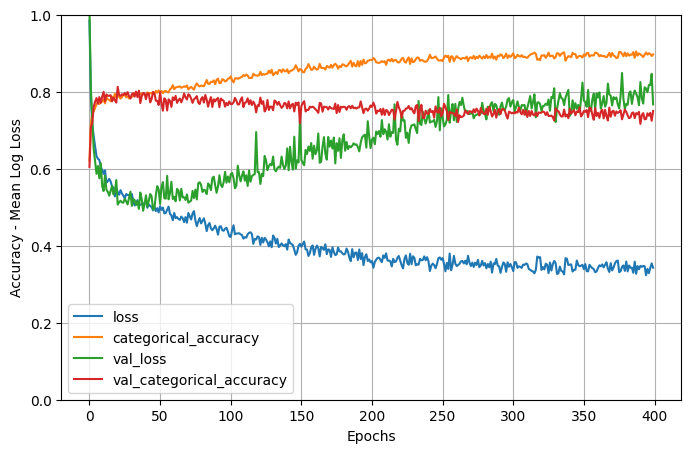

In [11]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
training_accuracy = round(results.categorical_accuracy.values[-1:][0]*100, 2)
val_accuracy = round(results.val_categorical_accuracy.values[-1:][0]*100, 2)
training_error = round((1 - results.categorical_accuracy.values[-1:][0])*100, 2)
test_error = round((1 - results.val_categorical_accuracy.values[-1:][0])*100, 2)
human_error = 5
bias = round(training_error - human_error, 2)
variance = round(test_error - training_error, 2)
training_time = round(end_time - start_time)
print("Error (training):", training_error, "%")
print("Error (test):", test_error, "%")
print("Bias:", bias)
print("Variance:", variance)
print("Time: ", training_time, "seconds")

Error (training): 10.3 %
Error (test): 25.0 %
Bias: 5.3
Variance: 14.7
Time:  948 seconds


In [13]:
def draw_confusion_matrix(cm, categories, normalize=True):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3*pow(len(categories), 0.5), 2*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(12-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)


51/51 [==============================] - 0s 3ms/step


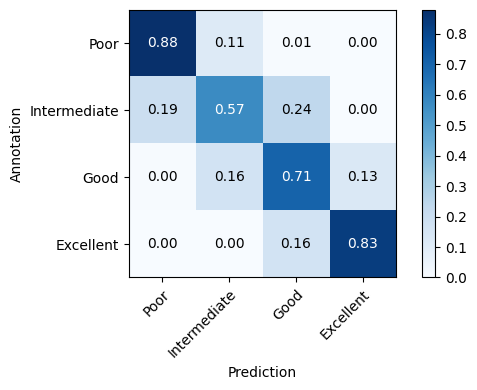

In [14]:
labels_pred = my_model.predict(instances_dev)
cm = confusion_matrix(np.argmax(labels_dev, axis=1), np.argmax(labels_pred, axis=1))
draw_confusion_matrix(cm, ["Poor", "Intermediate", "Good", "Excellent"])

## Step 8: Save results

In [15]:
RESULTS_FOLDER = "../Results"
RESULTS_FILE = f"{RESULTS_FOLDER}/models_performance.csv"

In [20]:
results_df = pd.read_csv(RESULTS_FILE, index_col = 0)

In [17]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'batch_size',
    'activation',
    'loss',
    'optimizer',
    'regularization',
    'train_accuracy',
    'validation_accuracy',
    'bias',
    'variance',
    'training_time'
]

new_result = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    BATCH_SIZE,
    ACTIVATION,
    "categorical_crossentropy",
    "ADAM b109 b20999",
    "l2 0.001",
    training_accuracy,
    val_accuracy,
    bias,
    variance,
    training_time]]

new_result_df = pd.DataFrame(new_result, columns=COLUMNS)
concatenation = pd.concat([results_df, new_result_df], ignore_index=True)
concatenation.to_csv(RESULTS_FILE)


In [21]:
last_five = results_df.tail(5)
# last_five = concatenation.tail(5)
print(last_five)
print("\n---Metrics---")
print(last_five[["train_accuracy", "validation_accuracy", "bias", "variance", "training_time"]].describe())

               model_name  epochs  learning_rate  batch_size activation  \
50  D128_BN_D64_BN_D32_BN     400            1.0          64       tanh   
51  D128_BN_D64_BN_D32_BN     400            1.0          64       tanh   
52  D128_BN_D64_BN_D32_BN     400            1.0          64       tanh   
53  D128_BN_D64_BN_D32_BN     400            1.0          64       tanh   
54  D128_BN_D64_BN_D32_BN     400            1.0          64       tanh   

                        loss         optimizer regularization  train_accuracy  \
50  categorical_crossentropy  ADAM b109 b20999       l2 0.001           89.18   
51  categorical_crossentropy  ADAM b109 b20999       l2 0.001           89.56   
52  categorical_crossentropy  ADAM b109 b20999       l2 0.001           88.49   
53  categorical_crossentropy  ADAM b109 b20999       l2 0.001           89.70   
54  categorical_crossentropy  ADAM b109 b20999       l2 0.001           89.23   

    validation_accuracy  bias  variance  training_time  
50   

In [19]:
MODELS_FOLDER = "../Models"
save_name = f"{MODELS_FOLDER}/{model_name}-1.h5"
my_model.save(save_name)